### An analysis in the Glitne field with Gassmann fluid substitution

#### Synthetic test based on the work of [Smith et al. (2003)](https://library.seg.org/doi/10.1190/1.1567211) - "Gassmann fluid substitutions: A tutorial" 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import avo_func2 as avo
from IPython.display import Image
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
np.random.seed(0)

#### Input properties

In [3]:
#vp, vs, rho - from figure 7, the velocities are converted to m/s
shale = np.array([2970,1370,2.41])
sandgas = np.array([2428,1462,2.08])
brine = np.array([2865, 1395, 2.28])

print("        Vp(m/s)  Vs(m/s)  Density(g/cc)\n")
print("Shale   %0.2f  %0.2f  %0.2f\n"%(tuple(shale)))
print("Gas     %0.2f  %0.2f  %0.2f\n"%(tuple(sandgas)))
print("Brine   %0.2f  %0.2f  %0.2f"%(tuple(brine)))

        Vp(m/s)  Vs(m/s)  Density(g/cc)

Shale   2970.00  1370.00  2.41

Gas     2428.00  1462.00  2.08

Brine   2865.00  1395.00  2.28


#### The properties will generate the logs

In [4]:
vp1 = np.zeros(100) + shale[0] 
vs1 = np.zeros(100) + shale[1]
rho1 = np.zeros(100) + shale[2]
facies1 = np.zeros(100)

vp2 = np.zeros(100) + sandgas[0]
vs2 = np.zeros(100) + sandgas[1] 
rho2 = np.zeros(100) + sandgas[2] 
facies2 = np.zeros(100) + 1

vp3 = np.zeros(100) + brine[0]
vs3 = np.zeros(100) + brine[1] 
rho3 = np.zeros(100) + brine[2] 
facies3 = np.zeros(100) + 2

vp_input=np.concatenate((vp1,vp2,vp1,vp3))
vs_input=np.concatenate((vs1,vs2,vs1,vs3))
rho_input=np.concatenate((rho1,rho2,rho1,rho3))
faceis_vet=np.concatenate((facies1,facies2,facies1,facies3))
faceis_vet2=np.concatenate((facies1,facies3,facies1,facies3)) #for fluid substitution

#### Add noise

In [5]:
vp = vp_input + np.random.normal(0,np.max(vp_input)*0.015,len(vp_input))
vs = vs_input + np.random.normal(0,np.max(vs_input)*0.015,len(vs_input))
rho = rho_input + np.random.normal(0,np.max(rho_input)*0.008,len(rho_input))

### Gassmann

In [6]:
#select the gas reservoir area
vp_in = vp[100:200] 
vs_in = vs[100:200]
rho_in = rho[100:200]

phi=0.25 #assumed from figure 8
#gas density & bulk modulus - from figure 5
rho_f1, k_f1=0.25,0.207
#brine density & bulk modulus - from figure 5
rho_f2, k_f2=1.04,2.95
k0=37 # from table 1 - assuming that is quartz

vp_out, vs_out, rho_out = avo.gassmann(vp_in,vs_in,rho_in,phi,k0,k_f1,rho_f1,k_f2,rho_f2)

#### Incorporate in the logs

In [7]:
vp2=np.concatenate((vp[:100],vp_out,vp[200:]))
vs2=np.concatenate((vs[:100],vs_out,vs[200:]))
rho2=np.concatenate((rho[:100],rho_out,rho[200:]))

### Poisson ratio, acoustic impedance and elastic impedance

In [8]:
vpvs_gas=vp/vs
vpvs_brine=vp2/vs2
#poisson ratio
pr_gas=avo.pr(vp,vs)
pr_brine=avo.pr(vp2,vs2)
#acoustic impedance
ai_gas=avo.ai(vp,rho)
ai_brine=avo.ai(vp2,rho2)
#elastic impedance
angle=30
ei_gas=avo.ei(vp,vs,rho,angle) 
ei_brine=avo.ei(vp2,vs2,rho2,angle)

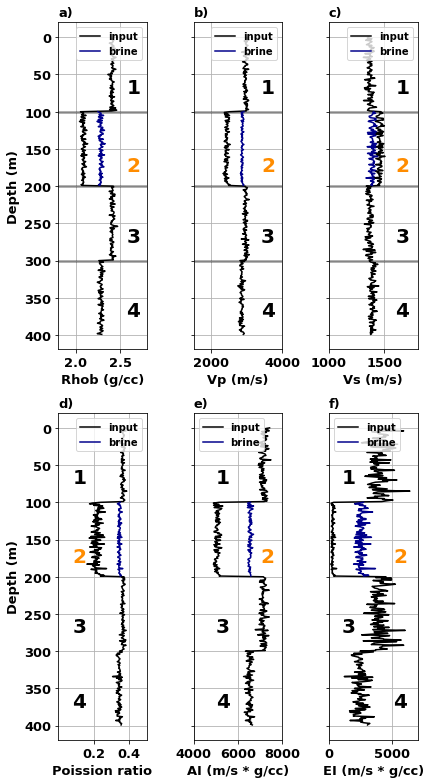

In [9]:
fig=plt.figure(figsize=(6,11))

ax=plt.subplot(2,3,1)
plt.title('a)',loc='left',fontsize=13)
plt.plot(rho,np.arange(rho.shape[0]),color='black',label='input')
plt.plot(rho_out,np.arange(100,200,1),color='darkblue',label='brine')
ax.set_xlim(1.8,2.8)
ax.invert_yaxis()
ax.set_xlabel("Rhob (g/cc)", fontsize=13)
ax.set_ylabel("Depth (m)", fontsize=13)
ax.legend()
ax.grid()
ax.tick_params(labelsize=13)
plt.text(2.57,75,'1', fontsize=20)
plt.text(2.57,180,'2', fontsize=20,color='darkorange')
plt.text(2.57,275,'3', fontsize=20)
plt.text(2.57,375,'4', fontsize=20)
ax.hlines(100,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(200,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(300,1.5,3,colors='black',alpha=0.3,linewidth=3)

ax=plt.subplot(2,3,2)
plt.title('b)',loc='left',fontsize=13)
plt.plot(vp,np.arange(vp.shape[0]),color='black',label='input')
plt.plot(vp_out,np.arange(100,200,1),color='darkblue',label='brine')
ax.set_xlim(1500,4000)
ax.invert_yaxis()
ax.set_xlabel("Vp (m/s)", fontsize=13)
ax.legend()
ax.grid()
ax.tick_params(labelsize=13)
plt.text(3400,75,'1', fontsize=20)
plt.text(3400,180,'2', fontsize=20,color='darkorange')
plt.text(3400,275,'3', fontsize=20)
plt.text(3400,375,'4', fontsize=20)
ax.hlines(100,1500,4500,colors='black',alpha=0.3,linewidth=3)
ax.hlines(200,1500,4500,colors='black',alpha=0.3,linewidth=3)
ax.hlines(300,1500,4500,colors='black',alpha=0.3,linewidth=3)
ax.set_yticklabels([])

ax=plt.subplot(2,3,3)
plt.title('c)',loc='left',fontsize=13)
plt.plot(vs,np.arange(vs.shape[0]),color='black',label='input')
plt.plot(vs_out,np.arange(100,200,1),color='darkblue',label='brine')
ax.set_xlim(1000,1800)
ax.invert_yaxis()
ax.set_xlabel("Vs (m/s)", fontsize=13)
ax.legend()
ax.grid()
ax.tick_params(labelsize=13)
plt.text(1600,75,'1', fontsize=20)
plt.text(1600,180,'2', fontsize=20,color='darkorange')
plt.text(1600,275,'3', fontsize=20)
plt.text(1600,375,'4', fontsize=20)
ax.hlines(100,1000,2000,colors='black',alpha=0.3,linewidth=3)
ax.hlines(200,1000,2000,colors='black',alpha=0.3,linewidth=3)
ax.hlines(300,1000,2000,colors='black',alpha=0.3,linewidth=3)
ax.set_yticklabels([])

ax=plt.subplot(2,3,4)
plt.title('d)',loc='left',fontsize=13)
ax.set_xlabel('Poission ratio',fontsize=13)
ax.set_ylabel('Depth (m)',fontsize=13)
plt.plot(pr_gas,np.arange(pr_gas.shape[0]),color='black',label='input')
plt.plot(pr_brine[100:200],np.arange(100,200,1),color='darkblue',label='brine')
ax.invert_yaxis()
ax.grid()
ax.legend()
ax.tick_params(labelsize=13)
ax.set_xlim(0,0.5)
ax.set_xticks([0.2,0.4])
plt.text(0.08,75,'1', fontsize=20)
plt.text(0.08,180,'2', fontsize=20,color='darkorange')
plt.text(0.08,275,'3', fontsize=20)
plt.text(0.08,375,'4', fontsize=20)
ax.hlines(100,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(200,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(300,1.5,3,colors='black',alpha=0.3,linewidth=3)

ax=plt.subplot(2,3,5)
plt.title('e)',loc='left',fontsize=13)
ax.set_xlabel('AI (m/s * g/cc)',fontsize=13)
plt.plot(ai_gas,np.arange(ai_gas.shape[0]),color='black',label='input')
plt.plot(ai_brine[100:200],np.arange(100,200,1),color='darkblue',label='brine')
ax.invert_yaxis()
ax.grid()
ax.legend()
ax.tick_params(labelsize=13)
ax.set_xlim(4000,8000)
plt.text(5000,75,'1', fontsize=20)
plt.text(7000,180,'2', fontsize=20,color='darkorange')
plt.text(5000,275,'3', fontsize=20)
plt.text(5000,375,'4', fontsize=20)
ax.hlines(100,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(200,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(300,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.set_yticklabels([])


ax=plt.subplot(2,3,6)
plt.title('f)',loc='left',fontsize=13)
ax.set_xlabel('EI (m/s * g/cc)',fontsize=13)
plt.plot(ei_gas,np.arange(ei_gas.shape[0]),color='black',label='input')
plt.plot(ei_brine[100:200],np.arange(100,200,1),color='darkblue',label='brine')
ax.invert_yaxis()
ax.grid()
ax.legend()
ax.tick_params(labelsize=13)
ax.set_xlim(0,7000)
plt.text(1000,75,'1', fontsize=20)
plt.text(5100,180,'2', fontsize=20,color='darkorange')
plt.text(1000,275,'3', fontsize=20)
plt.text(5100,375,'4', fontsize=20)
ax.hlines(100,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(200,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.hlines(300,1.5,3,colors='black',alpha=0.3,linewidth=3)
ax.set_yticklabels([])

plt.tight_layout()

plt.savefig('figures/figure1.png',dpi=500, bbox_inches='tight')

#### AVO with Shuey 3-term

In [10]:
angle = np.arange(0,31,1)
top = 100
delta = 25
#top of gas
I_tg,G_tg,_,shuey_tg = avo.shuey(vp[top-delta],vs[top-delta],rho[top-delta],vp[top+delta],vs[top+delta],rho[top+delta],angle)

#top of brine - after gassmann
I_tb,G_tb,_,shuey_tb = avo.shuey(vp2[top-delta],vs2[top-delta],rho2[top-delta],vp2[top+delta],vs2[top+delta],rho2[top+delta],angle)

print('Intercept gas:   %0.3f   Gradient gas:   %0.3f'%(I_tg,G_tg))
print('Intercept brine: %0.3f   Gradient brine: %0.3f'%(I_tb,G_tb))

Intercept gas:   -0.155   Gradient gas:   -0.071
Intercept brine: -0.030   Gradient brine: 0.005


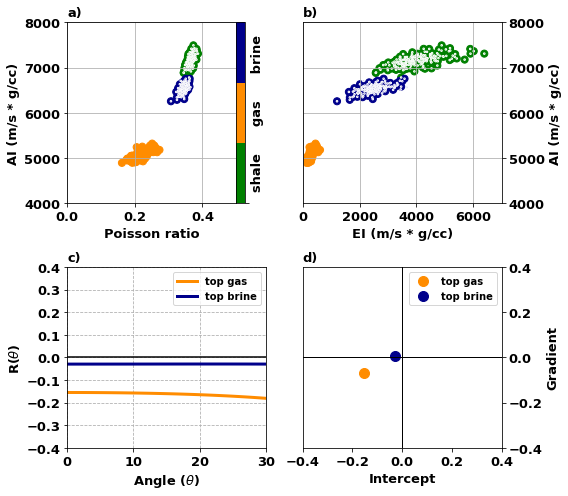

In [11]:
#      0=shale 1=gas 2=brine 
ccc = ['green','darkorange','darkblue']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

mxplot=0.4

fig=plt.figure(figsize=(8,7))

ax3=plt.subplot(2,2,1)
ax3.set_title('a)',loc='left',fontsize=13)
plt.scatter(pr_gas,ai_gas,50,c=faceis_vet,cmap=cmap_facies,marker='o')
plt.scatter(pr_brine,ai_brine,10,c=faceis_vet2,cmap=cmap_facies,marker='.',edgecolors='white')
ax3.set_xlim(0,0.5)
ax3.set_ylim(4000,8000)
plt.grid(True)
ax3.set_xlabel('Poisson ratio', fontsize=13)
ax3.set_ylabel('AI (m/s * g/cc)', fontsize=13)
cbar=plt.colorbar(pad=0)
cbar.set_label((6*' ').join(['shale','gas','brine']),size=13,labelpad=-1)
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
ax3.tick_params(labelsize=13)

ax4=plt.subplot(2,2,2)
ax4.set_title('b)',loc='left',fontsize=13)
plt.scatter(ei_gas,ai_gas,50,c=faceis_vet,cmap=cmap_facies,marker='o')
plt.scatter(ei_brine,ai_brine,10,c=faceis_vet2,cmap=cmap_facies,marker='.',edgecolors='white')
ax4.set_ylim(4000,8000)
ax4.set_xlim(0,7000)
plt.grid(True)
ax4.set_xlabel('EI (m/s * g/cc)', fontsize=13)
ax4.set_ylabel('AI (m/s * g/cc)', fontsize=13)
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=13)

ax1=plt.subplot(2,2,3)
ax1.set_title('c)',loc='left',fontsize=13)
ax1.plot(angle,shuey_tg,'-',color='darkorange',linewidth=3,label='top gas')
ax1.plot(angle,shuey_tb,'-',color='darkblue',linewidth=3,label='top brine')
ax1.axhline(0, color='k')
ax1.set_xlabel('Angle ($\\theta$)', fontsize=13)
ax1.set_ylabel('R($\\theta$)', fontsize=13)
yt=np.linspace(-mxplot,mxplot,6)
ax1.set_yticks(yt)
ax1.set_xlim(0.,np.max(angle))
ax1.set_ylim(-mxplot,mxplot)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='--')
ax1.legend(ncol=1)
ax1.set_yticks(np.linspace(-0.4,0.4,9))

ax2=plt.subplot(2,2,4)
ax2.set_title('d)',loc='left',fontsize=13)
ax2.plot(I_tg,G_tg,'o',color='darkorange',markersize=10,label='top gas')
ax2.plot(I_tb,G_tb,'o',color='darkblue',markersize=10,label='top brine')
ax2.axhline(0, color='k', lw=1)
ax2.axvline(0, color='k', lw=1)
ax2.set_xlabel('Intercept', fontsize=13)
ax2.set_ylabel('Gradient', fontsize=13)
ax2.set_xlim(-mxplot,mxplot)
ax2.set_ylim(-mxplot,mxplot)
yt=np.linspace(-mxplot,mxplot,6)
xt=np.linspace(-mxplot,mxplot,6)
ax2.set_yticks(yt)
ax2.set_xticks(xt)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.tick_bottom()
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.tick_params(labelsize=13)
ax2.set_yticks(np.linspace(-0.4,0.4,5))
ax2.set_xticks(np.linspace(-0.4,0.4,5))
ax2.legend(ncol=1)

plt.tight_layout()

plt.savefig('figures/figure2.png',dpi=500, bbox_inches='tight')

### References:

Amato del Monte, A. 2015b. Seismic petrophysics: Part 2. The Leading Edge, 34(6), 700-704.

Avseth, P.; Mukerji, T.; Jørstad, A.; Mavko, G.; Veggeland, T. 2001. Seismic reservoir mapping from 3-D AVO in a North Sea turbidite system. Geophysics, 66(4), 1157-1176.

Avseth, P., Mukerji, T., & Mavko, G., 2005. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

Connolly, P., 1999, Elastic impedance: The Leading Edge, 18, 438–452.

Shuey,R.T., 1985, A simplification of Zoeppritz equations: Geophysics, 50, 609–614.

Smith, T.M; Sondergeld, C.H.; Rai. C.S. 2003. Gassmann fluid substitutions: A tutorial. Geophysics, 68: 430-440.

https://github.com/aadm/avo_explorer